# Pytorch与MNIST

## 说明

程序源代码参考：https://github.com/pytorch/examples/blob/master/mnist/main.py

本代码实现最简单的三层神经网络，全是线性层，不含卷积。

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 

## MNIST数据集

MNIST的图像数据是28像素×28像素的灰度图像（1通道），各个像素的取值在0到255之间。每个图像都相应地标有“1”、“2”、“3”等标签

## 设定网络结构

- 第一个__init__是初始化的参数，包含三个全连接层(fc)。

```Python
class torch.nn.Linear(in_features, out_features, bias=True)
```

>fc1采用线性变换层实现，输入样本大小为28\*28，输出样本大小为50。
>
>fc2采用线性变换层实现，输入样本大小为50，输出样本大小为100。
>
>fc3采用线性变换层实现，输入样本大小为100，输出样本大小为10，由于这是最后一层（不算输出层），所以10就是10个类别。
>
>说明：其中的50和100可以自己设置。

- 第二个函数forward指的是前向传播。

  前向传播指明了传播方向，即从fc1依次经过fc2、fc3，最后经过log_softmax输出结果。


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=100)
        self.fc2 = nn.Linear(in_features=100, out_features=50)
        self.fc3 = nn.Linear(in_features=50, out_features=10)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

## 加载MNIST集

MNIST下载完毕后会有4个文件，分别是：

>train-images.idx3-ubyte 训练集X
>
>train-labels.idx1-ubyte 训练集y
>
>t10k-images.idx3-ubyte 测试集X
>
>t10k-labels.idx1-ubyte 测试集y

Pytorch的torchvision已经有封装好的MNIST数据集类，我们在这里直接使用。

```Python
from torchvision import datasets
datasets.MNIST(root, train=True, transform=None, target_transform=None, download=False)
```

其中：
- root：指的是下载路径，这里人工指定为'./MNIST_data'
- train：True就是训练集，False就是测试集
- download：True指的是如果没有数据集则下载，如果有就不下载。
- transform：指的是数据变换增强，比如翻转，拉伸等等。在这一步我们先检查数据，不使用。

In [13]:
mnist_trainset = datasets.MNIST(root='./MNIST_data/MNIST', train=True, download=True, transform=None)
mnist_testset = datasets.MNIST(root='./MNIST_data/MNIST', train=False, download=True, transform=None)

现在我们一起来康康这些数据集有多大。

可以看出训练集有60000条数据而测试集有10000条数据。

In [14]:
print(len(mnist_trainset))
print(len(mnist_testset))

60000
10000


检查一下mnist_trainset的第一个元素是什么东西？

结果表明，这是一个PIL.Image，而且其类型是tuple类型。

In [15]:
mnist_trainset[0]

(<PIL.Image.Image image mode=L size=28x28 at 0x7F18500DB080>, tensor(5))

In [16]:
type(mnist_trainset[0])

tuple

使用 show() 函数来展示图像，并且康康这个图像对应的标签。

该图片的标签是：  tensor(7)


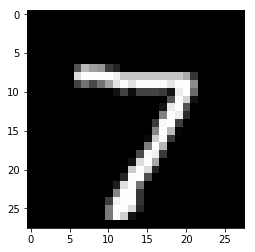

In [17]:
test_image_zero, test_target_zero = mnist_testset[0]
plt.imshow(test_image_zero, cmap ='gray')  # 灰度图像
print("该图片的标签是： ",test_target_zero)

### 数据集抽象化

上面的mnist_trainset和mnist_testset只是读取了相关数据，但是为了让Pytorch能够使用这些数据，还需要使用数据加载起将其抽象化。

数据加载器如下：

```Python
class torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False, sampler=None, num_workers=0, collate_fn=<function default_collate>, pin_memory=False, drop_last=False)
```
- dataset (Dataset)：加载数据的数据集。
- batch_size (int, optional)： 每个batch加载多少个样本(默认: 1)。
- shuffle (bool, optional)：设置为True时会在每个epoch重新打乱数据(默认: False).
- sampler (Sampler, optional)：定义从数据集中提取样本的策略。如果指定，则忽略shuffle参数。
- num_workers (int, optional)：用多少个子进程加载数据。0表示数据将在主进程中加载(默认: 0)
- collate_fn (callable, optional)
- pin_memory (bool, optional)
- drop_last (bool, optional)：如果数据集大小不能被batch size整除，则设置为True后可删除最后一个不完整的batch。如果设为False并且数据集的大小不能被batch size整除，则最后一个batch将更小。(默认: False)

现在重新读取数据，因为要放入网络计算，我们是不能使用PIL.image格式的，需要转换为Tensor形式。
需要说明的是，在transforms中我们使用了ToTensor和正规化的方法，其中：
- Compose：是将多个transform组合起来使用的方法
- ToTensor：这里把一个取值范围是[0,255]的PIL.Image转换成形状为[C,H,W]，取值范围是[0,1.0]的torch.FloadTensor
- Normalize：给定均值mean和方差std，这里会把Tensor正则化。

**注意：针对PIL图像必须ToTensor，否则后面不能运算**

In [18]:
data_tf = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.1307,), (0.3081,))])

mnist_trainset = datasets.MNIST(root='./MNIST_data/MNIST', train=True, download=True, transform=data_tf)
mnist_testset = datasets.MNIST(root='./MNIST_data/MNIST', train=False, download=True, transform=data_tf)

train_loader = DataLoader(mnist_trainset, batch_size=1000, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=1000, shuffle=True)

## 训练网络

在检查完毕数据集以后，我们要开始网络的训练了。之前在第一部分已经建立好了一个简单的三层神经网络。

### 初始化网络

前面我们已经建立好网络了，在这里将网络（参数等）初始化，顺便判断CUDA是否可用。

In [30]:
# 初始化网络
net = Net()
if torch.cuda.is_available():  # 如果GPU可以使用
    net = net.cuda()
    print("CUDA is available.")

CUDA is available.


### 设置优化器

优化器的种类很多，包括但不限于：

- SGD：随机梯度下降
- Momentum：带动量的梯度下降
- AdaGrad：带学习率衰减的梯度下降
- Adam：结合了动量和学习率衰减的梯度下降

这里我们使用最简单的SGD，也就是随机梯度下降,用法如下：

```Python
class torch.optim.SGD(params, lr=, momentum=0, dampening=0, weight_decay=0, nesterov=False)
```
- params (iterable) – 待优化参数的iterable或者是定义了参数组的dict
- lr (float) – 学习率
- momentum (float, 可选) – 动量因子（默认：0）
- weight_decay (float, 可选) – 权重衰减（L2惩罚）（默认：0）
- dampening (float, 可选) – 动量的抑制因子（默认：0）
- nesterov (bool, 可选) – 使用Nesterov动量（默认：False）

In [31]:
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)  # 传入 net 的所有参数, 学习率

### 设置损失函数

损失函数的计算也有很多种，这里我们使用交叉熵作为我们的损失函数计算方法，用法如下：

```Python
class torch.nn.CrossEntropyLoss(weight=None, size_average=True)
```

In [32]:
loss_func = torch.nn.CrossEntropyLoss()

### 开始训练

需要说明的几点

1. 第一个 if 判断的是CUDA是否可用，这里其实没有使用CUDA，可以无视。
2. optimizer.step() 用于更新参数，大多数优化器都实现了step()函数
3. img刚刚读取的时候，其 size 为 torch.Size([1000, 1, 28, 28])，是一个四维数组，需要变换才可使用。
>为什么要变换后使用？
>
>因为这里我们用的是Linear层，只能接受1维度数组。如果使用卷积层，就可以接受二维图像了。
4. 初始化网络后才能设置优化器和损失函数，不能先设置损失函数和优化器再初始化网络。
5. 每次反向传播之前必须先把梯度归零。
6. torch.nn.Module.train():就是训练模式,在此模式中会启用Dropout()

In [33]:
# 5个epoch
net.train()  # 启用train模式
for epoch in range(5):
    for batch_ndx, data in enumerate(train_loader):  # 按照一个batch = 1000来抽取数据
        img, label = data
        # print(img.size())
        img = img.view(img.size(0), -1)  # 展开为一维数组
        if torch.cuda.is_available():
            img = img.cuda()
            label = label.cuda()
            # print("使用CUDA训练")
        else:
            pass
        
        # 前向传播
        output = net(img)
        loss = loss_func(output, label)
        
        # 反向传播
        optimizer.zero_grad()  # 梯度归零
        loss.backward()  # 损失函数反向传播
        optimizer.step()
        
        if batch_ndx%10 == 0:
            print('epoch: {}, batch_ndx: {}, loss: {:.4}'.format(epoch, batch_ndx, loss.data.item()))    

epoch: 0, batch_ndx: 0, loss: 2.295
epoch: 0, batch_ndx: 10, loss: 2.136
epoch: 0, batch_ndx: 20, loss: 1.997
epoch: 0, batch_ndx: 30, loss: 1.856
epoch: 0, batch_ndx: 40, loss: 1.734
epoch: 0, batch_ndx: 50, loss: 1.6
epoch: 1, batch_ndx: 0, loss: 1.493
epoch: 1, batch_ndx: 10, loss: 1.386
epoch: 1, batch_ndx: 20, loss: 1.256
epoch: 1, batch_ndx: 30, loss: 1.157
epoch: 1, batch_ndx: 40, loss: 1.118
epoch: 1, batch_ndx: 50, loss: 0.9991
epoch: 2, batch_ndx: 0, loss: 1.025
epoch: 2, batch_ndx: 10, loss: 0.9333
epoch: 2, batch_ndx: 20, loss: 0.8374
epoch: 2, batch_ndx: 30, loss: 0.8372
epoch: 2, batch_ndx: 40, loss: 0.7532
epoch: 2, batch_ndx: 50, loss: 0.7075
epoch: 3, batch_ndx: 0, loss: 0.7214
epoch: 3, batch_ndx: 10, loss: 0.6841
epoch: 3, batch_ndx: 20, loss: 0.6959
epoch: 3, batch_ndx: 30, loss: 0.6821
epoch: 3, batch_ndx: 40, loss: 0.6326
epoch: 3, batch_ndx: 50, loss: 0.5712
epoch: 4, batch_ndx: 0, loss: 0.6039
epoch: 4, batch_ndx: 10, loss: 0.6247
epoch: 4, batch_ndx: 20, loss: 

### 开始测试

需要说明几点：
1. torch.nn.Module.eval()：将模型变为评估模式，此模式关闭Dropour()

>效果等同于 torch.nn.Module.train(False)

2. label.size(0)这里是一个batch的大小，就是1000。
3. eval_loss 就等于每一个batch的loss乘以1000再累加。最后再把累加起来的loss，除以测试集总数，就是预计的loss。
4. eval_acc 同理。先计算每个batch中pred和label相等的数量（正确数量），然后累加，最后除以测试集总数，就是实际的acc。
5. 注意：loss.data.item()才是真正的损失值，如果直接使用loss，返回的实际上是一个loss图，会导致显存爆炸。

In [24]:
net.eval()
eval_loss = 0
eval_acc = 0

# 对测试集进行测试
for batch_ndx, data in enumerate(test_loader):
    # 获得img(手写图片)，label标签（手写图片对应数字）
    img, label = data
    img = img.view(img.size(0), -1)
    if torch.cuda.is_available():
        img = img.cuda()
        label = label.cuda()
    
    #  向前传播，获得out结果和损失函数
    output = net(img)
    loss = loss_func(output, label)  # 交叉熵
    
    # 损失函数乘标签大小累计
    eval_loss += loss.data.item()*label.size(0)  # 每个计算一次损失？
    # 在10维数据中，获得最大的预测值（即预测数）
    _, pred = torch.max(output, 1)
    # 判断是否与真实结果相同
    num_correct = (pred == label).sum()
    
    # 累计真实结果
    eval_acc += num_correct.item()

print(label.size(0))
# 输出评估结果    
print('Test Loss: {:.6f}, Acc: {:.6f}'.format(
    eval_loss / (len(mnist_testset)),
    eval_acc / (len(mnist_testset))
))

1000
Test Loss: 0.501702, Acc: 0.874500


In [26]:
loss.data.item()

0.5187490582466125

## 绘制图像（临时）

### Visdom安装

https://github.com/facebookresearch/visdom

```Shell
pip install visdom
```

### Visdom启动

打开Powershell，运行如下命令，然后在浏览器中访问：http://localhost:8097

```Shell
visdom
```

然后运行如下代码，如果visdom窗口有所显示，则说明成功。

In [172]:
# visdom hello world
import visdom
import numpy as np
vis = visdom.Visdom()
vis.text('Hello, World!')
tr_loss=list(range(100))
viz.line(Y=np.array(tr_loss), opts=dict(showlegend=True))
vis.image(np.ones((3, 10, 10)))

'window_378f6192562c1a'